### Load & Save

In [27]:
import pandas as pd
from pathlib import Path
import os
import kagglehub
import warnings
from collections import defaultdict
from sklearn.preprocessing import FunctionTransformer
import json

warnings.filterwarnings("ignore")
%matplotlib inline

root_path = Path(os.getcwd()).parent
dataset_filename = "houses_Madrid.csv"
save_path = root_path / "data" / dataset_filename
DATASET_SCHEME = defaultdict(list)

if save_path.exists():
    df = pd.read_csv(save_path)
else:
    download_dir = (
        Path(kagglehub.dataset_download("mirbektoktogaraev/madrid-real-estate-market"))
        / dataset_filename
    )
    df = pd.read_csv(download_dir, index_col="id")
    df = df.drop(columns=["Unnamed: 0"])
    df.to_csv(save_path)


print(df.shape)
df.head()

(21742, 57)


,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,True,True,True,True


### Explore target

As the exact problem to solve is not stated, let's assume solving a regression problem for buying prices. \
This might require certain transformations for the target.

count    2.174200e+04
mean     6.537356e+05
std      7.820821e+05
min      3.600000e+04
25%      1.980000e+05
50%      3.750000e+05
75%      7.636000e+05
max      8.800000e+06
Name: buy_price, dtype: float64

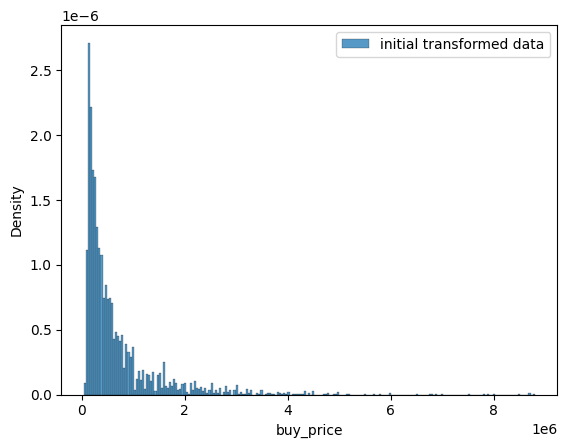

In [28]:
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


def _get_histplot(feature: pd.Series):
    sns.histplot(feature, stat="density", kde=False, label="initial transformed data")
    plt.legend()


_get_histplot(df["buy_price"])
df["buy_price"].describe()

Target seems approximately lognormally distributed. At least, it is \
in fact skewed like as if it was. Let's test for it.

The pvalue of 3.272519457234605e-213 with the threshold of 0.01 suggests that 'buy_price' is lognormally distributed.


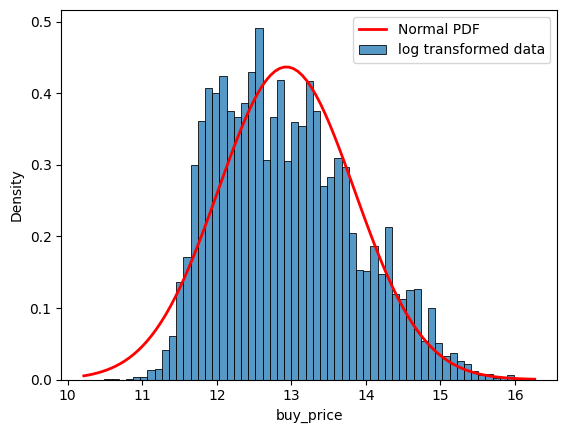

In [29]:
def log_normality_check(frame: pd.DataFrame, feature_name: str):
    # Test for log-normality. log1p is unnecessary, since min(target) = 36000 > 1.
    log_feature = np.log(frame[feature_name])

    pvalue = sp.stats.mstats.normaltest(log_feature, axis=0).pvalue
    threshold = 0.01
    print(
        f"The pvalue of {pvalue} with the threshold of {threshold} suggests that \
'{feature_name}' is {'not ' if pvalue >= threshold else ''}lognormally distributed."
    )

    # Plot overlapping transformed data and normal distribution with its params
    _, ax = plt.subplots()
    sns.histplot(
        log_feature, ax=ax, stat="density", kde=False, label="log transformed data"
    )

    mean, deviation = np.mean(log_feature), np.std(log_feature)
    x = np.linspace(*ax.get_xlim(), 100)
    norm_pdf = sp.stats.norm.pdf(x, mean, deviation)

    ax.plot(x, norm_pdf, "r", linewidth=2, label="Normal PDF")

    plt.legend()


log_normality_check(df, "buy_price")

In [30]:
# Let's prepare a transforms pipeline
@FunctionTransformer
def convert_target(frame: pd.DataFrame) -> pd.DataFrame:
    """Applies target transformations.

    Applies log transform to the target, since it was
    shown o exhibit lognormal distribution earlier.

    Parameters
    ----------
    frame : pd.DataFrame
        initial / previous step frame

    Returns
    -------
    pd.DataFrame
        frame with changed target
    """

    frame["buy_price"] = np.log(frame["buy_price"])
    return frame


pipe = [convert_target]
DATASET_SCHEME["target"] = "buy_price"

### Explore features.
This section's concern is about basic preprocessing. \
For core features or groups of features, I'll decide on the way to treat/preprocess/encode each.

#### Square meters

This is one of the most useful features and for all used samples I'll \
have to ieither estimate/restore it, or delete the samples with absent values alltogether.

Let's explore absent values, the correlatin with the target and related features.

##### Explore

In [31]:
df["sq_mt_built"].isna().value_counts()

sq_mt_built
False    21616
True       126
Name: count, dtype: int64

In [32]:
df["sq_mt_useful"].isna().value_counts()

sq_mt_useful
True     13514
False     8228
Name: count, dtype: int64

In [33]:
df["n_rooms"].isna().value_counts()

n_rooms
False    21742
Name: count, dtype: int64

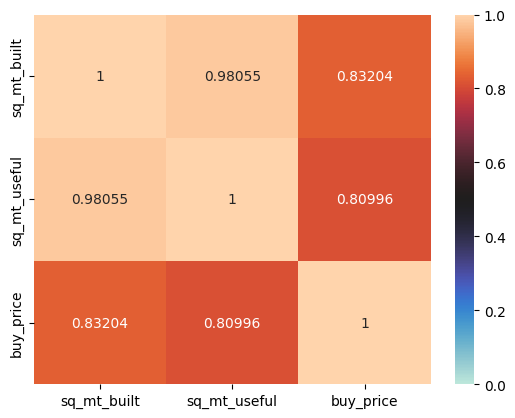

In [34]:
sns.heatmap(
    df[["sq_mt_built", "sq_mt_useful", "buy_price"]].corr(),
    vmin=0,
    center=0.5,
    annot=True,
    fmt=".5g",
);

Apparently, there're 126 missing 'sq_mt_built' values, of which 18 have sq_mt_useful, \
however only 9 of which have actually meaningful values in this column, since those \
other 9 cases have multiple rooms and bathrooms stated given only 1 useful square meter. \
Additionally, the 'sq_mt_useful' feature has multiple missing values. As such, I need to both \
somehow restore 'sq_mt_built' and 'sq_mt_useful', because deleting either clumn is wasteful and \
both could be useful. I shall restore them both, look and the correlation matrix and then \
decide whether it is worth deleteing 'sq_mt_useful', since its rebuilt version shall heavily depend on 'sq_mt_built'.


Please, note how highly correlated the features are to the target before log transform. \
This likely implies the features requiring the same transform. Once finishd with \
the exploration part, I'll need to verify this.

##### Transform

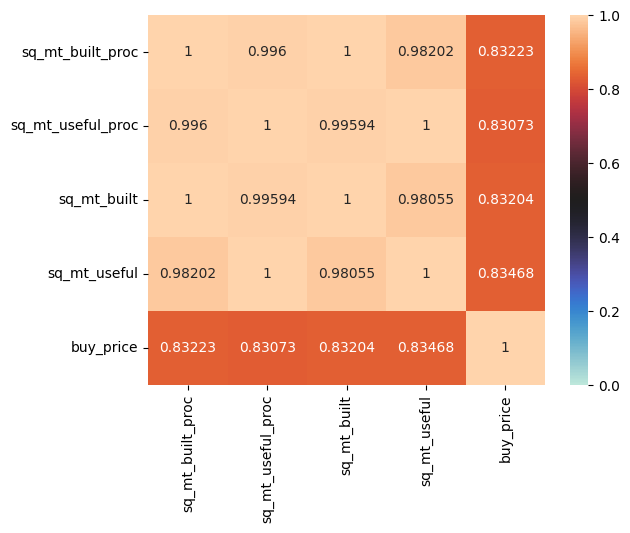

In [35]:
def process_square_meters(frame: pd.DataFrame) -> pd.DataFrame:
    """Process square meters columns.

    Mutually restores sq_mt_built and sq_mt_useful. Some entries are deleted
    if no meaningful value is provided for either of the columns.

    Parameters
    ----------
    frame : pd.DataFrame
        initial / previous step frame

    Returns
    -------
    pd.DataFrame
        frame with new features
    """

    # Derive portion of the dataset, where both features are present
    minimum_sq_mt = frame["n_rooms"].fillna(0) + frame["n_bathrooms"].fillna(0)
    sq_mt_built_present = ~frame["sq_mt_built"].isna()
    sq_mt_useful_present = ~frame["sq_mt_useful"].isna()
    sq_mt_built_meaningful = frame["sq_mt_built"] > minimum_sq_mt
    sq_mt_useful_meaningful = frame["sq_mt_useful"] > minimum_sq_mt
    clean_frame = frame[["sq_mt_built", "sq_mt_useful", "n_rooms", "n_bathrooms"]][
        sq_mt_built_present
        & sq_mt_useful_present
        & sq_mt_built_meaningful
        & sq_mt_useful_meaningful
    ][["sq_mt_built", "sq_mt_useful"]]

    # Derive median ratio of built/useful square meters and restore both columns
    median_ratio = (clean_frame["sq_mt_built"] / clean_frame["sq_mt_useful"]).median()

    frame = frame[
        (sq_mt_built_present & sq_mt_built_meaningful)
        | (sq_mt_useful_present & sq_mt_useful_meaningful)
    ]

    frame["sq_mt_built_proc"] = frame["sq_mt_built"]
    frame["sq_mt_built_proc"].loc[frame["sq_mt_built_proc"].isna()] = (
        frame["sq_mt_useful"].loc[frame["sq_mt_built_proc"].isna()] * median_ratio
    )

    frame["sq_mt_useful_proc"] = frame["sq_mt_useful"]
    frame["sq_mt_useful_proc"].loc[frame["sq_mt_useful_proc"].isna()] = (
        frame["sq_mt_built"].loc[frame["sq_mt_useful_proc"].isna()] / median_ratio
    )

    # Add square meters numbers' presence
    frame["sq_mt_built_present"] = sq_mt_built_present & sq_mt_built_meaningful
    frame["sq_mt_useful_present"] = sq_mt_useful_present & sq_mt_useful_meaningful

    return frame


df_sq_mt = process_square_meters(df)

sns.heatmap(
    df_sq_mt[
        [
            "sq_mt_built_proc",
            "sq_mt_useful_proc",
            "sq_mt_built",
            "sq_mt_useful",
            "buy_price",
        ]
    ].corr(),
    vmin=0,
    center=0.5,
    annot=True,
    fmt=".5g",
);

##### Verify

The pvalue of 0.0 with the threshold of 0.01 suggests that 'sq_mt_built_proc' is lognormally distributed.


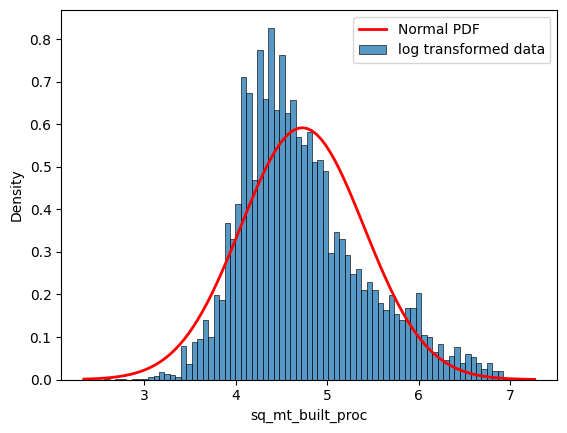

In [36]:
log_normality_check(df_sq_mt, "sq_mt_built_proc")

The pvalue of 0.0 with the threshold of 0.01 suggests that 'sq_mt_useful_proc' is lognormally distributed.


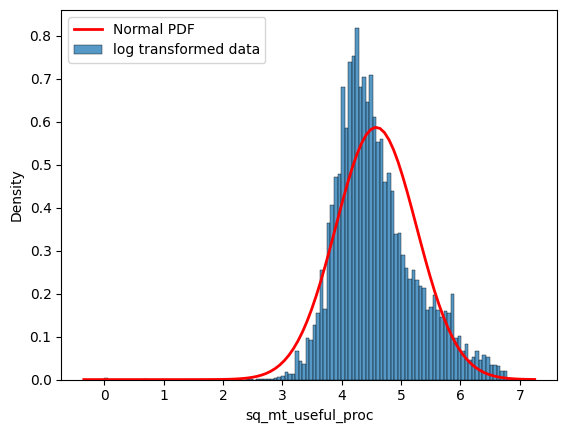

In [37]:
log_normality_check(df_sq_mt, "sq_mt_useful_proc")

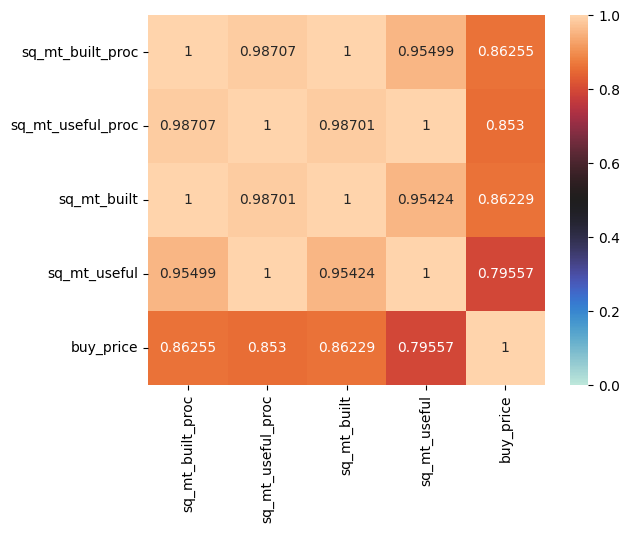

In [38]:
df_sq_mt = convert_target.fit_transform(df_sq_mt)

df_sq_mt["sq_mt_built_proc"] = np.log(df_sq_mt["sq_mt_built_proc"])
df_sq_mt["sq_mt_useful_proc"] = np.log(df_sq_mt["sq_mt_useful_proc"])
df_sq_mt["sq_mt_built"] = np.log(df_sq_mt["sq_mt_built"])
df_sq_mt["sq_mt_useful"] = np.log(df_sq_mt["sq_mt_useful"])

sns.heatmap(
    df_sq_mt[
        [
            "sq_mt_built_proc",
            "sq_mt_useful_proc",
            "sq_mt_built",
            "sq_mt_useful",
            "buy_price",
        ]
    ].corr(),
    vmin=0,
    center=0.5,
    annot=True,
    fmt=".5g",
);

The pvalues are extremely low (not an error, metric is indeed very high, manually checked). \
We can safely conclude that the features are indeed lognorally distributed, hence corresponding \
transform is required. It's pleasant to see how Pearson's coefficients have risen after the \
transforms, it show howvariance has slightly dropped.

Augmented transform function redefies the one from step earlier in the cell below:

In [ ]:
@FunctionTransformer
def process_square_meters(frame: pd.DataFrame) -> pd.DataFrame:
    """Process square meters columns.

    - Mutually restores 'sq_mt_built' and 'sq_mt_useful'. Some entries are deleted
    if no meaningful value is provided for either of the columns.
    - Applies log transform to the derived features 'sq_mt_built_proc' and 'sq_mt_useful_proc'.
    - Adds features 'sq_mt_built_present' and 'sq_mt_useful_present' of the presence for
    'sq_mt_built' and 'sq_mt_useful' respectfully.

    Parameters
    ----------
    frame : pd.DataFrame
        initial / previous step frame

    Returns
    -------
    pd.DataFrame
        frame with new features
    """

    # Derive portion of the dataset, where both features are present
    minimum_sq_mt = frame["n_rooms"].fillna(0) + frame["n_bathrooms"].fillna(0)
    sq_mt_built_present = ~frame["sq_mt_built"].isna()
    sq_mt_useful_present = ~frame["sq_mt_useful"].isna()
    sq_mt_built_meaningful = frame["sq_mt_built"] > minimum_sq_mt
    sq_mt_useful_meaningful = frame["sq_mt_useful"] > minimum_sq_mt
    clean_frame = frame[["sq_mt_built", "sq_mt_useful", "n_rooms", "n_bathrooms"]][
        sq_mt_built_present
        & sq_mt_useful_present
        & sq_mt_built_meaningful
        & sq_mt_useful_meaningful
    ][["sq_mt_built", "sq_mt_useful"]]

    # Derive median ratio of built/useful square meters and restore both columns
    median_ratio = (clean_frame["sq_mt_built"] / clean_frame["sq_mt_useful"]).median()

    frame = frame[
        (sq_mt_built_present & sq_mt_built_meaningful)
        | (sq_mt_useful_present & sq_mt_useful_meaningful)
    ]

    frame["sq_mt_built_proc"] = frame["sq_mt_built"]
    frame["sq_mt_built_proc"].loc[frame["sq_mt_built_proc"].isna()] = (
        frame["sq_mt_useful"].loc[frame["sq_mt_built_proc"].isna()] * median_ratio
    )

    frame["sq_mt_useful_proc"] = frame["sq_mt_useful"]
    frame["sq_mt_useful_proc"].loc[frame["sq_mt_useful_proc"].isna()] = (
        frame["sq_mt_built"].loc[frame["sq_mt_useful_proc"].isna()] / median_ratio
    )

    # Apply log transform to new features
    frame["sq_mt_built_proc"] = np.log(frame["sq_mt_built_proc"])
    frame["sq_mt_useful_proc"] = np.log(frame["sq_mt_useful_proc"])

    # Add square meters numbers' presence
    frame["sq_mt_built_present"] = (
        sq_mt_built_present & sq_mt_built_meaningful
    ).astype(int)
    frame["sq_mt_useful_present"] = (
        sq_mt_useful_present & sq_mt_useful_meaningful
    ).astype(int)

    return frame


pipe.append(process_square_meters)

##### Result

'sq_mt_built_proc' and 'sq_mt_useful_proc' now comprise each others' data when their own \
is absent. However, this restoration created highly correlated features. Taking them both \
will only complicate the task for the model, so I'll take only 'sq_mt_built_proc', since \
it's closer to the target. I additionally created features depicting absence of each number \
for square meters, since those would be bolean features that contribute less to the model \
overfitting due to less cardinality.

So the selected features are: 'sq_mt_built_proc', 'sq_mt_built_present', 'sq_mt_useful_present'.

In [40]:
DATASET_SCHEME["features"].extend(
    ["sq_mt_built_proc", "sq_mt_built_present", "sq_mt_useful_present"]
)

In [41]:
DATASET_SCHEME

defaultdict(list,
            {'target': 'buy_price',
             'features': ['sq_mt_built_proc',
              'sq_mt_built_present',
              'sq_mt_useful_present']})

#### Geopositional features

In this section I explore what geodata is present in the dataset, which could be used and under which conditions.

##### Exploration

In [42]:
df[["raw_address", "street_name"]].isna().value_counts().reset_index()

,raw_address,street_name,count
0,False,False,15837
1,True,True,5465
2,False,True,440


Quarter of the addresses is missing, probably part of those present\
 is bearly usable, I either need to restore the feature before \
 encoding or to drop/replace it.

In [43]:
df[["latitude", "longitude"]].isna().value_counts().reset_index()

,latitude,longitude,count
0,True,True,21742


Although exact coordinates' fields are there, they contain only None values 

In [44]:
df["neighborhood_id"].isna().value_counts()

neighborhood_id
False    21742
Name: count, dtype: int64

Apparently, this field has no missing value. Let us check its consistency \
by writing a regex to find all strings of the format: \
_'Neighborhood {some integer}: {some non-empty string} \
({some float} €/m2) - District {some integer}: {some non-empty string}'_

In [45]:
neighborhood_regex = r"Neighborhood\s+(\d+):\s+([^(]+)\s+\(([0-9]+(?:\.[0-9]+)?)\s+€/m2\)\s+-\s+District\s+(\d+):\s+(.+)"

df["neighborhood_id"].str.match(neighborhood_regex).all()

np.False_

In [46]:
df["neighborhood_id"].str.match(neighborhood_regex).value_counts(dropna=False)

neighborhood_id
True     21660
False       82
Name: count, dtype: int64

In [47]:
df[~df["neighborhood_id"].str.match(neighborhood_regex)]["neighborhood_id"]

5774     Neighborhood 80: Horcajo (None €/m2) - Distric...
5780     Neighborhood 79: Pavones (None €/m2) - Distric...
5795     Neighborhood 79: Pavones (None €/m2) - Distric...
5800     Neighborhood 79: Pavones (None €/m2) - Distric...
5804     Neighborhood 80: Horcajo (None €/m2) - Distric...
                               ...                        
21400    Neighborhood 79: Pavones (None €/m2) - Distric...
21410    Neighborhood 79: Pavones (None €/m2) - Distric...
21596    Neighborhood 43: Atalaya (None €/m2) - Distric...
21606    Neighborhood 43: Atalaya (None €/m2) - Distric...
21608    Neighborhood 43: Atalaya (None €/m2) - Distric...
Name: neighborhood_id, Length: 82, dtype: object

In [48]:
# New regex to also capture None values
neighborhood_regex_none = r"Neighborhood\s+(\d+):\s+([^(]+)\s+\(([^ ]+)\s+€/m2\)\s+-\s+District\s+(\d+):\s+(.+)"
df["neighborhood_id"].str.match(neighborhood_regex_none).all()

np.True_

Great news: all strings match the regex, except for 82 samples where \
average prices per square meter are not specified. This means two important things:
- I can restore district coordinates
- I can restopre neighbourhood coordinates
- I can clusterise coordinates to approximate missing prices per square \
meter via neighboring ones. Per se, I could take average prices of N neighbors. \

**Note for the future**: It is also a worthy idea to train a separate model to predict missing \
prices per square meter based on the distance from each neighborhood. This would be a \
little more resource and time consuming approach, but less naive and more sophisticated.  

In [49]:
df["neighborhood_id"].str.match(
    r"Neighborhood\s+(\d+):\s+([^(]+)\s+\(([^ ]+)\s+€/m2\)\s+-\s+District\s+(\d+):\s+(.+)"
).all()

np.True_

In [50]:
df[
    ~df["neighborhood_id"].str.match(
        r"Neighborhood\s+(\d+):\s+([^(]+)\s+\(([0-9]+(?:\.[0-9]+)?)\s+€/m2\)\s+-\s+District\s+(\d+):\s+(.+)"
    )
]["neighborhood_id"]

5774     Neighborhood 80: Horcajo (None €/m2) - Distric...
5780     Neighborhood 79: Pavones (None €/m2) - Distric...
5795     Neighborhood 79: Pavones (None €/m2) - Distric...
5800     Neighborhood 79: Pavones (None €/m2) - Distric...
5804     Neighborhood 80: Horcajo (None €/m2) - Distric...
                               ...                        
21400    Neighborhood 79: Pavones (None €/m2) - Distric...
21410    Neighborhood 79: Pavones (None €/m2) - Distric...
21596    Neighborhood 43: Atalaya (None €/m2) - Distric...
21606    Neighborhood 43: Atalaya (None €/m2) - Distric...
21608    Neighborhood 43: Atalaya (None €/m2) - Distric...
Name: neighborhood_id, Length: 82, dtype: object

##### Extraction
Key steps for each neighborhood id:
- Split the id into district name, neighborhood name and price per square meter if stated.
- Using geopy derive coordinates for district and neighborhood.
- Coordinates must be transformed into the distance from a fixed point (city's center) \
and bearing (angle).
- The bearing is better cyclically encoded into its cosine and sine for better fitting.

In [51]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.location import Location
from geopy.exc import GeocoderTimedOut
from tenacity import retry, wait_fixed, stop_after_attempt
from tqdm.auto import tqdm


NEIGHBORHOOD_FEATURE_NAMES = [
    "sq_mt_price",
    "center_distance",
    "bearing_sin",
    "bearing_cos",
    "latitude",
    "longitude",
]
NEIGHBORHOOD_INDICES = [
    *NEIGHBORHOOD_FEATURE_NAMES,
    "neighborhood_name",
    "district_name",
]
RESTORE_PRICE_NEIGHBORS = 3
RETRY_WAIT = 2
STOP_AFTER_ATTEMPT = 10
LOCATOR_TIMEOUT = 10


@retry(wait=wait_fixed(RETRY_WAIT), stop=stop_after_attempt(STOP_AFTER_ATTEMPT))
def _geocode_retry(locator: Nominatim, query: str) -> Location:
    return locator.geocode(query)


def get_distance_and_bearing(
    latitude1, longitude1, latitude2, longitude2
) -> tuple[float, float, float]:
    """Encodes coordinate relative to base.

    This function takes coordinates of 2 points and encodes
    second point relative to the first. The logic behind the
    encoding is to get distance and bearing, which are like
    polar coordinates, but are in fact geodesic, then convert
    angular bearing into its cosine and sine to cyclically
    (trigonometrically) encode the angle.

    Parameters
    ----------
    latitude1 : _type_
        base latitude
    longitude1 : _type_
        base longitude
    latitude2 : _type_
        encoded point's latitude
    longitude2 : _type_
        encoded point's longitude

    Returns
    -------
    tuple[float, float, float]
        tuple[distance, bearing_sin, bearing_cos]
    """
    point1 = (latitude1, longitude1)
    point2 = (latitude2, longitude2)

    # Geodesic distance in km
    distance = geodesic(point1, point2).km

    # Calculate initial bearing in radians
    lat1_rad = np.radians(latitude1)
    lon1_rad = np.radians(longitude1)
    lat2_rad = np.radians(latitude2)
    lon2_rad = np.radians(longitude2)

    delta_lon = lon2_rad - lon1_rad

    y = np.sin(delta_lon) * np.cos(lat2_rad)
    x = np.cos(lat1_rad) * np.sin(lat2_rad) - np.sin(lat1_rad) * np.cos(
        lat2_rad
    ) * np.cos(delta_lon)

    initial_bearing_radians = np.arctan2(y, x)

    # Apply cyclic transformation
    bearing_sin = np.sin(initial_bearing_radians)
    bearing_cos = np.cos(initial_bearing_radians)

    return distance, bearing_sin, bearing_cos


def split_neighbourhood_id(
    neighborhood_id: str,
    locator: Nominatim | None = None,
    center_point: Location | None = None,
) -> tuple[str, str, float | None, float, float, float, float, float]:
    """Splits a neighborhood_id into separate features.

    neighborhood_id has the following format:
    "Neighborhood {int}: {neighborhood name} ({price per square meter or 'None'} €/m2) - District {int}: {district name}"
    This allows separation into a tuple of (neighborhood_name, district_name, sq_mt_price).

    Next step is deriving and encoding coordinates from the location. The encoding is polar coordinates with
    geodesic distance from the city's center and cyclically (trigonometrically) encoded bearing to the point.
    The distance, sin and cos are return for neighborhood.

    Parameters
    ----------
    neighborhood_id : str
        A string of the following format:
        "Neighborhood {int}: {neighborhood_name} ({sq_mt_price} €/m2) - District {int}: {district_name}"

    Returns
    -------
    tuple[str, str, float | None, float, float, float]
        (neighborhood_name, district_name, sq_mt_price, center_distance_neighborhood, bearing_sin_neighborhood,
        bearing_cos_neighborhood, neighborhood_latitude, neighborhood_longitude)
    """

    if locator is None:
        locator = Nominatim(user_agent="my_geocoding_app")

    if center_point is None:
        center_point = locator.geocode("Madrid")

    neighborhood_name = neighborhood_id.split(" (")[0].split(": ")[1]
    neighborhood_name = neighborhood_name.split("-")[0].strip().replace(" de ", " ")
    sq_mt_price = neighborhood_id.split("(")[1].split(" €/m2)")[0]

    # Since isdigit and isnumeric don't capture floats, a try clause is needed
    try:
        sq_mt_price = float(sq_mt_price)
    except ValueError:
        sq_mt_price = None
    district_name = neighborhood_id.split(": ")[-1]

    # Get distrit coordinates
    district_query = f"Madrid, {district_name}"
    try:
        district_location = _geocode_retry(locator, district_query)
        district_latitude, district_longitude = (
            district_location.latitude,
            district_location.longitude,
        )
    except GeocoderTimedOut as e:
        print(f"Query '{district_query}' Failed.")
        raise e

    # Get neighborhood coordinates
    neighborhood_query = f"Madrid, {neighborhood_name}"
    try:
        neighborhood_location = _geocode_retry(locator, neighborhood_query)
        if neighborhood_location is None:
            neighborhood_latitude, neighborhood_longitude = (
                district_latitude,
                district_longitude,
            )
        else:
            neighborhood_latitude, neighborhood_longitude = (
                neighborhood_location.latitude,
                neighborhood_location.longitude,
            )
    except GeocoderTimedOut as e:
        print(f"Query '{neighborhood_query}' Failed.")
        raise e

    # Convert coordinates into distance and bearing from city's center,
    # better alternative to the polar coordinates
    center_distance_neighborhood, bearing_sin_neighborhood, bearing_cos_neighborhood = (
        get_distance_and_bearing(
            center_point.latitude,
            center_point.longitude,
            neighborhood_latitude,
            neighborhood_longitude,
        )
    )

    return (
        neighborhood_name,
        district_name,
        sq_mt_price,
        center_distance_neighborhood,
        bearing_sin_neighborhood,
        bearing_cos_neighborhood,
        neighborhood_latitude,
        neighborhood_longitude,
    )


@FunctionTransformer
def process_neighborhoods(frame: pd.DataFrame) -> pd.DataFrame:
    """Prepares and encodes neihborhoods' features.

    It splits neighborhood ids, then using geopy derives coordinats
    for the districts and neighborhoods. Then it encodes the coordinates
    into geodesic polar ones - bearing transformation with geodesic
    distance and trigonometric cyclic encoding. Fills out gaps in price per
    square meter data and handles geopy errors in neighborhood location
    via using districts' data.

    Parameters
    ----------
    frame : pd.DataFrame
        previous step frame

    Returns
    -------
    pd.DataFrame
        frame with added features

    Raises
    ------
    e
        Errors impossible to handle. These arise if geopy completely
        fails due to network errors or poor data.
    """
    # Read or create a table for all neighborhood ids
    neighborhoods_data_path = root_path / "data" / "neighborhoods.csv"
    if (neighborhoods_data_path).exists():
        neighborhoods_data = pd.read_csv(neighborhoods_data_path, index_col=0)
    else:
        neighborhood_id_mapping = {}
        locator = Nominatim(user_agent="my_geocoding_app", timeout=LOCATOR_TIMEOUT)
        center_point = locator.geocode("Madrid")
        for idx, id in tqdm(list(enumerate(frame["neighborhood_id"].unique()))):
            if id not in neighborhood_id_mapping:
                try:
                    neighborhood_id_mapping[id] = pd.Series(
                        split_neighbourhood_id(
                            id, center_point=center_point, locator=locator
                        ),
                        index=NEIGHBORHOOD_FEATURE_NAMES,
                    )
                except Exception as e:
                    print(f"{id}, index: {idx}")
                    raise e
        neighborhoods_data = pd.DataFrame(neighborhood_id_mapping).T
        neighborhoods_data.to_csv(neighborhoods_data_path)

    # The sq_mt_price restoration part
    ids_to_restore = list(
        neighborhoods_data[neighborhoods_data["sq_mt_price"].isna()].index
    )

    distances = {
        restore_id: {
            target_id: geodesic(
                (
                    neighborhoods_data.loc[restore_id]["latitude"],
                    neighborhoods_data.loc[restore_id]["longitude"],
                ),
                (
                    neighborhoods_data.loc[target_id]["latitude"],
                    neighborhoods_data.loc[target_id]["longitude"],
                ),
            ).km
            for target_id in neighborhoods_data[
                ~neighborhoods_data.index.isin(ids_to_restore)
            ].index
        }
        for restore_id in ids_to_restore
    }
    distances_df = pd.DataFrame(distances).T
    nearest_neighbors = distances_df.apply(
        lambda candidates: pd.Series(
            candidates.nsmallest(RESTORE_PRICE_NEIGHBORS).index
        ),
        axis=1,
    )
    restored_prices = nearest_neighbors.apply(
        lambda neighbors: np.mean(
            [neighborhoods_data.loc[neighbor, "sq_mt_price"] for neighbor in neighbors]
        ),
        axis=1,
    )
    neighborhoods_data["sq_mt_price"] = neighborhoods_data["sq_mt_price"].fillna(
        restored_prices
    )

    # Once prices are restored, the features should be mapped onto the dataset
    return frame.drop(columns=["latitude", "longitude"]).merge(
        neighborhoods_data, how="left", left_on="neighborhood_id", right_index=True
    )


pipe.append(process_neighborhoods)
DATASET_SCHEME["features"].extend(NEIGHBORHOOD_FEATURE_NAMES)

#### Miscellaneous Features

In [52]:
df.drop(
    columns=[*DATASET_SCHEME["features"], DATASET_SCHEME["target"]], errors="ignore"
)

,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,raw_address,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,"Calle de Godella, 64",...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,Calle de la del Manojo de Rosas,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,"Calle del Talco, 68",...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,Calle Pedro Jiménez,...,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,Carretera de Villaverde a Vallecas,...,en trámite,True,NaN,NaN,True,0.0,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,5,Ático en venta en Casco Histórico de Barajas,"Barajas, Madrid",78.0,NaN,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN
21738,4,Piso en venta en Urb. Campo de las Naciones - ...,"Barajas, Madrid",96.0,83.0,2,2.0,NaN,NaN,Urb. Campo de las Naciones - Corralejos,...,en trámite,True,NaN,NaN,True,0.0,False,True,True,True
21739,3,Piso en venta en Campo de las Naciones-Corralejos,"Barajas, Madrid",175.0,NaN,4,2.0,NaN,NaN,NaN,...,E,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN
21740,2,"Chalet adosado en venta en calle Burriana, 12","Campo de las Naciones-Corralejos, Madrid",289.0,NaN,4,3.0,3.0,304.0,"Calle Burriana, 12",...,en trámite,True,NaN,NaN,True,0.0,False,False,True,False


##### Boolean Features

In [53]:
BOOLEAN_FEATURES = [
    "is_floor_under",
    "has_central_heating",
    "has_individual_heating",
    "are_pets_allowed",
    "has_ac",
    "is_new_development",
    "is_renewal_needed",
    "has_fitted_wardrobes",
    "has_lift",
    "is_exterior",
    "has_garden",
    "has_pool",
    "has_terrace",
    "has_balcony",
    "has_storage_room",
    "is_furnished",
    "is_kitchen_equipped",
    "is_accessible",
    "has_green_zones",
    "has_parking",
    "has_private_parking",
    "has_public_parking",
    "is_parking_included_in_price",
    "is_orientation_north",
    "is_orientation_west",
    "is_orientation_south",
    "is_orientation_east",
]
boolean_table = df[BOOLEAN_FEATURES].apply(lambda x: x.value_counts(dropna=False)).T

boolean_table.sort_values(boolean_table.columns[-1], na_position="first")

,False,True,NaN
is_renewal_needed,17747.0,3995.0,NaN
has_parking,14023.0,7719.0,NaN
is_new_development,19281.0,1469.0,992.0
is_floor_under,18033.0,2539.0,1170.0
has_lift,4461.0,14895.0,2386.0
is_exterior,1777.0,16922.0,3043.0
has_individual_heating,4092.0,9516.0,8134.0
has_central_heating,9516.0,4092.0,8134.0
has_fitted_wardrobes,NaN,13399.0,8343.0
is_orientation_west,7287.0,4071.0,10384.0


There're several groups of boolean features, each requires its own handling:

1. **Complete.**
There're only 'is_renewal_needed' and 'has_parking' there. \
These features don't require any transformation.

2. **Empty.**
All the values here are None. These features are to be deleted.
- 'is_kitchen_equipped'
- 'is_furnished'
- 'are_pets_allowed'
- 'has_public_parking'
- 'has_private_parking'

3. **Polar.**
The feature is boolean, but there's either a True value or none stated. This is \
probably beacuse these feature state the presence of relatively rare things like pool, \
hence it's easy to assume 'False' for filling in the gaps. There're also those that \
don't completely match the description (there're some 'False' values), but \
it is hard to assume any filling for 'None' values except for "False", since if it was, \
it should've been stated in the description. These are: \
- is_parking_included_in_price
- has_individual_heating
- has_central_heating
- has_lift
- is_new_development
- is_floor_under
- is_exterior
- has_fitted_wardrobes

So all the **Polar** fatures given are:
- has_ac
- has_terrace
- is_parking_included_in_price
- has_storage_room
- has_pool
- is_accessible
- has_green_zones
- has_balcony
- has_garden
- has_individual_heating
- has_central_heating
- has_lift
- is_new_development
- is_floor_under
- is_exterior
- has_fitted_wardrobes

4. **Incomplete.**
These could be filled with False, but require an additional boolean feature of presence, \
since the value cannot be restored and absent feature could influence target:
- is_orientation_south
- is_orientation_north
- is_orientation_east
- is_orientation_west

In [54]:
ALL_BOOLEAN_FEATURES = [*BOOLEAN_FEATURES, "is_orientation_stated"]
COMPLETE_BOOLEAN_FEAURES = ["is_renewal_needed", "has_parking"]
EMPTY_BOOLEAN_FEATURES = [
    "is_kitchen_equipped",
    "is_furnished",
    "are_pets_allowed",
    "has_public_parking",
    "has_private_parking",
]
POLAR_BOOLEAN_FEATURES = [
    "has_ac",
    "has_terrace",
    "is_parking_included_in_price",
    "has_storage_room",
    "has_pool",
    "is_accessible",
    "has_green_zones",
    "has_balcony",
    "has_garden",
    "has_individual_heating",
    "has_central_heating",
    "has_lift",
    "is_new_development",
    "is_floor_under",
    "is_exterior",
    "has_fitted_wardrobes",
]
INCOMPLETE_BOOLEAN_FEATURES = [
    "is_orientation_south",
    "is_orientation_north",
    "is_orientation_east",
    "is_orientation_west",
]
NON_EMPTY_FEATURES = list(
    set(ALL_BOOLEAN_FEATURES).difference(set(EMPTY_BOOLEAN_FEATURES))
)


@FunctionTransformer
def process_boolean_features(frame: pd.DataFrame) -> pd.DataFrame:
    """Prepares boolean features.

    Fills incmplete and polar features with False. For orientation features adds
      new boolean feature of the orientation's presence.

    Parameters
    ----------
    frame : pd.DataFrame
        previous step frame

    Returns
    -------
    pd.DataFrame
        frame with added and processed features
    """
    # handle polar features
    frame[POLAR_BOOLEAN_FEATURES] = frame[POLAR_BOOLEAN_FEATURES].fillna(False)

    # handle incomplete features
    frame[INCOMPLETE_BOOLEAN_FEATURES] = frame[INCOMPLETE_BOOLEAN_FEATURES].fillna(
        False
    )
    frame["is_orientation_stated"] = frame[INCOMPLETE_BOOLEAN_FEATURES].any(axis=1)

    # Convert to binary
    frame[NON_EMPTY_FEATURES] = frame[NON_EMPTY_FEATURES].astype(int)
    return frame


pipe.append(process_boolean_features)
DATASET_SCHEME["features"].extend(NON_EMPTY_FEATURES)

##### Ordinal Features.

In [55]:
df.drop(
    columns=[*DATASET_SCHEME["features"], DATASET_SCHEME["target"]], errors="ignore"
)

,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,raw_address,...,is_buy_price_known,house_type_id,built_year,are_pets_allowed,is_furnished,is_kitchen_equipped,energy_certificate,has_private_parking,has_public_parking,parking_price
0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,"Calle de Godella, 64",...,True,HouseType 1: Pisos,1960.0,NaN,NaN,NaN,D,NaN,NaN,NaN
1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,Calle de la del Manojo de Rosas,...,True,HouseType 1: Pisos,NaN,NaN,NaN,NaN,en trámite,NaN,NaN,NaN
2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,"Calle del Talco, 68",...,True,HouseType 1: Pisos,NaN,NaN,NaN,NaN,no indicado,NaN,NaN,NaN
3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,Calle Pedro Jiménez,...,True,HouseType 1: Pisos,1955.0,NaN,NaN,NaN,en trámite,NaN,NaN,NaN
4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,Carretera de Villaverde a Vallecas,...,True,HouseType 1: Pisos,2003.0,NaN,NaN,NaN,en trámite,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,5,Ático en venta en Casco Histórico de Barajas,"Barajas, Madrid",78.0,NaN,2,2.0,NaN,NaN,NaN,...,True,HouseType 5: Áticos,2020.0,NaN,NaN,NaN,en trámite,NaN,NaN,0.0
21738,4,Piso en venta en Urb. Campo de las Naciones - ...,"Barajas, Madrid",96.0,83.0,2,2.0,NaN,NaN,Urb. Campo de las Naciones - Corralejos,...,True,HouseType 1: Pisos,2002.0,NaN,NaN,NaN,en trámite,NaN,NaN,0.0
21739,3,Piso en venta en Campo de las Naciones-Corralejos,"Barajas, Madrid",175.0,NaN,4,2.0,NaN,NaN,NaN,...,True,HouseType 1: Pisos,2002.0,NaN,NaN,NaN,E,NaN,NaN,0.0
21740,2,"Chalet adosado en venta en calle Burriana, 12","Campo de las Naciones-Corralejos, Madrid",289.0,NaN,4,3.0,3.0,304.0,"Calle Burriana, 12",...,True,HouseType 2: Casa o chalet,1981.0,NaN,NaN,NaN,en trámite,NaN,NaN,0.0


In [56]:
ALL_ORDINAL_FEATURES = [
    "energy_certificate",
    "built_year",
    "house_type_id",
    "n_rooms",
    "n_bathrooms",
    "n_floors",
]

In [57]:
df["energy_certificate"].value_counts(dropna=False)

energy_certificate
en trámite         10937
no indicado         3669
E                   2701
D                   1121
G                    894
F                    674
A                    618
C                    580
B                    452
inmueble exento       96
Name: count, dtype: int64

Energy certificate can be ncoded in the following order:
- no indicado
- en trámite
- G
- F
- E
- D
- C
- B
- A
- inmueble exento

It is also important to add a presence feature to ensure 'no indicado' \
can be clearly separated from the rest in one cut.

Vocabulary: 
- _no indicado_ - not indicated
- _en trámite_ - in progress
- _inmueble exento_ - exempt property

In [58]:
df["built_year"].value_counts(dropna=False).sort_index(na_position="first")

built_year
NaN       11742
1723.0        1
1800.0        2
1810.0        1
1848.0        1
          ...  
2019.0      117
2020.0       91
2021.0       11
2022.0       11
8170.0        1
Name: count, Length: 156, dtype: int64

In [59]:
df["built_year"].describe()

count    10000.000000
mean      1970.046400
std         69.386705
min       1723.000000
25%       1957.000000
50%       1970.000000
75%       1994.000000
max       8170.000000
Name: built_year, dtype: float64

Built year should be binned. There're many blank values, these should be put as \
the least, but also be separable in one cut, so I'll make a presence feature. \
I'll set the binning to 21 quantiles to make the scale most descrete, since \
all the values fall into 300 years interval. Invalid values should be handled as 'None'.

In [60]:
df["n_rooms"].value_counts(dropna=False)

n_rooms
3     7214
2     5499
4     3367
1     2267
5     1757
6      715
0      439
7      259
8      112
9       54
10      26
11      10
12       9
13       6
24       3
15       2
16       1
18       1
14       1
Name: count, dtype: int64

n_rooms is ordinal and has no missing values. Should be scaled.

In [61]:
df["n_bathrooms"].value_counts(dropna=False).sort_index(na_position="first")

n_bathrooms
NaN       16
1.0     9084
2.0     7408
3.0     2429
4.0     1170
5.0      871
6.0      422
7.0      182
8.0       94
9.0       37
10.0      13
11.0       7
12.0       1
13.0       3
14.0       3
15.0       1
16.0       1
Name: count, dtype: int64

'n_bathrooms' is also ordinal, but should be restored. Could be \
implemented through ratio with respect to the n_rooms.

In [62]:
df["n_floors"].value_counts(dropna=False)

n_floors
NaN    20305
4.0      567
3.0      476
2.0      316
1.0       56
5.0       21
7.0        1
Name: count, dtype: int64

Most of the values are missing, can be misleading. Should be dropped.

In [63]:
df["house_type_id"].value_counts(dropna=False)

house_type_id
HouseType 1: Pisos            17705
HouseType 2: Casa o chalet     1938
HouseType 5: Áticos            1032
HouseType 4: Dúplex             676
NaN                             391
Name: count, dtype: int64

house type could be one-hot encoded, or encoded ordinarily since the \
properties can be arranged in ascending order like:
None < Flat < Penthouse < Duplex < House

Vocabulary:
- Pisos - flat
- Casa o chalet - house
- Áticos - penthouses
- Dúplex - duplex

In [ ]:
from datetime import datetime

ENERGY_CERTIFICATE_ORDER = [
    "no indicado",
    "en trámite",
    "G",
    "F",
    "E",
    "D",
    "C",
    "B",
    "A",
    "inmueble exento",
]
HOUSE_TYPE_ORDER = [
    np.nan,
    "HouseType 1: Pisos",
    "HouseType 5: Áticos",
    "HouseType 4: Dúplex",
    "HouseType 2: Casa o chalet",
]


@FunctionTransformer
def process_ordinal_features(frame: pd.DataFrame) -> pd.DataFrame:
    # Process energy certificates. Set as indices in ordered list
    frame["energy_certificate_provided"] = (
        frame["energy_certificate"] == "no indicado"
    ).astype(int)
    frame["energy_certificate"] = frame["energy_certificate"].apply(
        lambda certificate: ENERGY_CERTIFICATE_ORDER.index(certificate)
    )

    # Process built_year
    frame["built_year"][~frame["built_year"].between(0, datetime.now().year)] = None
    labels = np.linspace(0, 1, 21).round(3)
    built_year_notna_mask = ~frame["built_year"].isna()
    frame["built_year"][built_year_notna_mask] = pd.qcut(
        frame["built_year"][built_year_notna_mask], q=21, labels=labels
    ).astype(float)
    frame["built_year"][frame["built_year"].isna()] = 0

    # Process n_rooms. Minmax transform
    frame["n_rooms"] = (frame["n_rooms"] - frame["n_rooms"].min()) / (
        frame["n_rooms"].max() - frame["n_rooms"].min()
    )

    # Process n_bathrooms. Restore from known samples
    bathrooms_stated_mask = ~frame["n_bathrooms"].isna()
    bathroom_coefficient = (
        frame[bathrooms_stated_mask]["n_rooms"]
        / frame[bathrooms_stated_mask]["n_bathrooms"]
    ).mean()
    frame["n_bathrooms"][~bathrooms_stated_mask] = (
        (frame[~bathrooms_stated_mask]["n_rooms"] / bathroom_coefficient)
        .round()
        .astype(int)
    )

    # Process house_type_id. Set as indices in ordered list
    frame["house_type_id"] = frame["house_type_id"].apply(
        lambda house_type_id: HOUSE_TYPE_ORDER.index(house_type_id)
    )

    return frame


pipe.append(process_ordinal_features)
DATASET_SCHEME["features"].extend(
    [
        "energy_certificate_provided",
        "energy_certificate",
        "built_year",
        "n_rooms",
        "n_bathrooms",
        "house_type_id",
    ]
)

In [71]:
(root_path / "data" / "dataset_schema.json").write_text(json.dumps(DATASET_SCHEME, indent=4));

In [65]:
pipe

[FunctionTransformer(func=<function convert_target at 0x0000022BC3BEA7A0>),
 FunctionTransformer(func=<function process_square_meters at 0x0000022BC33640E0>),
 FunctionTransformer(func=<function process_neighborhoods at 0x0000022BB9C64FE0>),
 FunctionTransformer(func=<function process_boolean_features at 0x0000022BB9C65120>),
 FunctionTransformer(func=<function process_ordinal_features at 0x0000022BB9C656C0>)]